# Tutorial: Integrating GWAS with Single-Cell Data using cellink
This tutorial demonstrates how to integrate GWAS (Genome-Wide Association Studies) data with single-cell genomics using [`scDRS`](https://www.nature.com/articles/s41588-022-01167-z) and [`Seismic`](https://www.nature.com/articles/s41467-025-63753-z) through the cellink package. `scDRS` identifies disease-relevant invididual cells, tests for heterogeneity within cell types and cell-level disease associations and correlates disease scores with cell-level variables. `Seismic` links cell types with traits and identifies influential genes driving associations. Both scDRS and seismic benefit from larger sample sizes. Aim for >50 donors and well-powered GWAS for robust results. The results depend on cell type granularity. Consider running analyses at multiple resolutions.

We also demonstrate how to identify relevant gene sets using MAGMA. Both tools work seamlessly with `cellink's` DonorData structure. To use `scDRS` please install cellink via pip install `'cellink[scdrs]'`. To use `Seismic` please install it via: `R -e "devtools::install_github('ylaboratory/seismicGWAS')"` and additionally install `rpy2` via: `pip install rpy2`.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba
numba.set_num_threads(1)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import scanpy as sc

from cellink.resources import get_dummy_onek1k, get_gwas_catalog_study_summary_stats
from cellink.tl.external import run_scdrs, run_seismic, run_magma_pipeline

dd = get_dummy_onek1k(
    config_path="../../src/cellink/resources/config/dummy_onek1k.yaml",
    verify_checksum=False
)
dd.G.obs["donor_id"] = dd.G.obs.index

print(f"Dataset shape: {dd.shape}")
print(f"Cell types: {dd.C.obs['predicted.celltype.l2'].unique()[:5]}")

[2026-01-07 22:40:04,377] INFO:root: /Users/larnoldt/cellink_data/dummy_onek1k/dummy_onek1k.dd.h5 already exists
[2026-01-07 22:40:04,377] WARNING:root: No checksum provided, skipping verification
[2026-01-07 22:40:05,436] INFO:root: Loaded dummy OneK1K dataset: (100, 146939, 125366, 34073)
Dataset shape: (100, 146939, 125366, 34073)
Cell types: ['gdT', 'NK', 'CD8 TEM', 'CD4 Naive', 'CD4 TCM']
Categories (31, object): ['ASDC', 'B intermediate', 'B memory', 'B naive', ..., 'cDC2', 'dnT', 'gdT', 'pDC']


We filter the DonorData object to speed-up the computation for demonstration purposes.

In [2]:
celltype_counts = dd.C.obs["predicted.celltype.l2"].value_counts()
celltypes_of_interest = celltype_counts[celltype_counts > 100].index
dd.C = dd.C[
    dd.C.obs["predicted.celltype.l2"].isin(celltypes_of_interest)
].copy()
dd.C = dd.C[:, dd.C.var["vst.variable"] == 1].copy()

We utilize a publicly available GWAS summary statistic, here for iunstance for Type 2 Diabetes.

In [3]:
gwas_df = get_gwas_catalog_study_summary_stats("GCST90018926")
gwas_df

[2026-01-07 22:40:06,467] INFO:root: Fetching https://www.ebi.ac.uk/gwas/rest/api/v2/studies/GCST90018926
[2026-01-07 22:40:06,924] INFO:root: Found harmonised file: GCST90018926.h.tsv.gz
[2026-01-07 22:40:06,925] INFO:root: Downloading http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90018001-GCST90019000/GCST90018926/harmonised/GCST90018926.h.tsv.gz to /Users/larnoldt/cellink_data/GCST90018926_summary_stats.tsv.gz


,chromosome,base_pair_location,effect_allele,other_allele,beta,standard_error,effect_allele_frequency,p_value,variant_id,hm_coordinate_conversion,hm_code,rsid
0,1,13668,A,G,-0.0732,0.1438,0.005726,0.61070,NaN,lo,10,rs2691328
1,1,14506,A,G,0.1447,0.1368,0.005608,0.29020,NaN,lo,10,rs1240557819
2,1,14717,A,G,0.1238,0.3071,0.000766,0.68690,NaN,lo,10,rs377122907
3,1,14773,T,C,0.0943,0.0842,0.017190,0.26270,NaN,lo,10,rs878915777
4,1,14860,T,G,0.2269,0.1052,0.011830,0.03102,NaN,lo,10,rs533499096
...,...,...,...,...,...,...,...,...,...,...,...,...
23493340,22,50801156,C,G,-0.0244,0.1173,0.005176,0.83520,NaN,lo,5,rs574579322
23493341,22,50801158,G,T,-0.0533,0.0839,0.006570,0.52520,NaN,lo,10,rs535432390
23493342,22,50801178,CA,C,-0.0785,0.1016,0.011780,0.43970,NaN,lo,10,rs1398339726
23493343,22,50801200,G,GT,-0.0370,0.1077,0.011400,0.73120,NaN,lo,10,rs1166777585


We convert the public GWAS statistic to gene-level statistics using MAGMA. MAGMA needs to be downloaded as shown below:

In [4]:
import requests, zipfile, io, os, stat

url = "https://vu.data.surf.nl/public.php/dav/files/1M1d9vHtVidEwvU/?accept=zip"

r = requests.get(url)
r.raise_for_status() 

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("magma")

for root, dirs, files in os.walk("magma"):
    for file in files:
        path = os.path.join(root, file)
        st = os.stat(path)
        os.chmod(path, st.st_mode | stat.S_IEXEC) 

In [5]:
custom_mapping = {
    "rsID": "SNP",
    "chromosome": "CHR",
    "base_pair_location": "BP",
    "p_value": "P",
}

magma_file = run_magma_pipeline(dd, gwas_df, output_prefix="trait", col_mapping=custom_mapping, n_samples=200000, magma_bin="./magma/magma", genome_build="GRCh37", gene_id_type="ensembl", config_file="../../configs/magma.yaml")

[2026-01-07 22:42:15,377] INFO:cellink.tl.external._magma: Starting MAGMA pipeline
[2026-01-07 22:42:15,378] INFO:cellink.tl.external._magma: Preparing MAGMA input files from DonorData
[2026-01-07 22:42:15,379] INFO:cellink.tl.external._magma: Downloading/checking gene location file
[2026-01-07 22:42:15,383] INFO:cellink.tl.external._magma: Using cached gene location file: /Users/larnoldt/cellink_data/magma_references/NCBI37.3.gene.loc
[2026-01-07 22:42:15,384] INFO:cellink.tl.external._magma: Using cached converted gene location file: /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc
[2026-01-07 22:42:15,384] INFO:cellink.tl.external._magma: Preparing SNP location and p-value files
[2026-01-07 22:42:49,213] INFO:cellink.tl.external._magma: Created SNP location file: trait.snp_loc.txt
[2026-01-07 22:43:04,332] INFO:cellink.tl.external._magma: Created p-value file: trait.p_val.txt
[2026-01-07 22:43:04,333] INFO:cellink.tl.external._magma: Exporting genotypes to PLINK

Writing BED: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

Writing FAM... done.
Writing BIM... 

done.
[2026-01-07 22:43:04,945] INFO:cellink.tl.external._magma: Created PLINK files: trait_ld_ref.{bed,bim,fam}
[2026-01-07 22:43:05,931] INFO:cellink.tl.external._magma: Running MAGMA SNP annotation
[2026-01-07 22:43:05,932] INFO:cellink.tl.external._magma: Running: ./magma/magma --annotate window=35,10 --snp-loc trait.snp_loc.txt --gene-loc /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc --out trait
[2026-01-07 22:43:29,578] INFO:cellink.tl.external._magma: Welcome to MAGMA v1.10 (custom)
Using flags:
	--annotate window=35,10
	--snp-loc trait.snp_loc.txt
	--gene-loc /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc
	--out trait

Start time is 22:43:06, Wednesday 07 Jan 2026

Starting annotation...
Reading gene locations from file /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc... 
	adding window: 35000bp (before), 10000bp (after)
	20134 gene locations read from file
	chromosome  1: 1964 genes
	chromosome  2: 1154 genes


## Part 1: scDRS Analysis - Cell-Level Disease Associations
scDRS identifies individual cells with excess expression of disease-associated genes and performs downstream analyses at the cell group level.

In [6]:
magma_results = pd.read_csv("trait.genes.out", sep=r'\s+')

top_genes = magma_results.nsmallest(1000, 'P')['GENE'].tolist()
gene_weights = magma_results.nsmallest(1000, 'P')['ZSTAT'].tolist()

gene_sets = {
    "Type2Diabetes": (top_genes, gene_weights)
}

### Running scDRS

In [7]:
results_scdrs, downstream_results = run_scdrs(
    dd.C,
    gene_sets=gene_sets,
    group_analysis=["predicted.celltype.l2"],  # Cell type column
    corr_analysis=["n_genes"],  # Cell-level variables
    gene_analysis=True,
    n_ctrl=1000,
    prefix="t2d_scdrs",
    save_results=True,
)

score_df = results_scdrs["Type2Diabetes"]
print(f"Computed scores for {len(score_df)} cells")
print(score_df.head())

ct_results = downstream_results["Type2Diabetes"]["group_predicted.celltype.l2"]
print("\nTop cell type associations:")
print(ct_results.sort_values("assoc_mcp").head())

[2026-01-07 22:43:38,496] INFO:cellink.tl.external._scdrs: Filtering cells and genes
[2026-01-07 22:43:38,805] INFO:cellink.tl.external._scdrs: Log-normalizing data


/opt/miniconda3/envs/single_cell_base3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


[2026-01-07 22:43:38,824] INFO:cellink.tl.external._scdrs: Preprocessing data for scDRS
Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=15
[2026-01-07 22:43:40,170] INFO:cellink.tl.external._scdrs: Computing scDRS scores for 1 trait(s)
[2026-01-07 22:43:40,170] INFO:cellink.tl.external._scdrs: Processing Type2Diabetes


Computing control scores: 100%|██████████| 1000/1000 [00:20<00:00, 49.14it/s]


[2026-01-07 22:44:06,630] INFO:cellink.tl.external._scdrs: Computing KNN graph for heterogeneity analysis
[2026-01-07 22:44:26,843] INFO:cellink.tl.external._scdrs: Performing group analysis for Type2Diabetes


/opt/miniconda3/envs/single_cell_base3/lib/python3.12/site-packages/scdrs/method.py:957: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df_group in df_meta.groupby(groupby):


[2026-01-07 22:45:14,608] INFO:cellink.tl.external._scdrs: Performing correlation analysis for Type2Diabetes
[2026-01-07 22:45:14,712] INFO:cellink.tl.external._scdrs: Performing gene analysis for Type2Diabetes
Computed scores for 12796 cells
                     raw_score  norm_score   mc_pval      pval  nlog10_pval  \
barcode                                                                       
CGTGTCTGTGTAAGTA-15  -0.001589   -0.681597  0.905095  0.766282     0.115611   
AGCTCTCAGGCTCATT-15  -0.001589   -0.681597  0.905095  0.766282     0.115611   
CCTTACGGTTGGAGGT-15  -0.001589   -0.681597  0.905095  0.766282     0.115611   
TCAGATGCACACGCTG-15  -0.001589   -0.681597  0.905095  0.766282     0.115611   
CTTGGCTCAGTTTACG-15  -0.001589   -0.681597  0.905095  0.766282     0.115611   

                       zscore  ctrl_norm_score_0  ctrl_norm_score_1  \
barcode                                                               
CGTGTCTGTGTAAGTA-15 -0.726658           0.281851          -0.

### Visualizing scDRS Results

We first visualize the distribution of the Norm socres and the cell types. Also we then plot the statistic to identify disease-relevant cell populations. Please note, that this is a dummy OneK1K dataset. 

[2026-01-07 22:45:14,768] INFO:cellink.tl.external._scdrs: Filtering cells and genes
[2026-01-07 22:45:14,829] INFO:cellink.tl.external._scdrs: Preprocessing data for scDRS
Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=15
[2026-01-07 22:45:16,169] INFO:cellink.tl.external._scdrs: Computing scDRS scores for 1 trait(s)
[2026-01-07 22:45:16,170] INFO:cellink.tl.external._scdrs: Processing Type2Diabetes


Computing control scores: 100%|██████████| 1000/1000 [00:18<00:00, 54.45it/s]
... storing 'donor_id' as categorical
... storing 'chrom' as categorical


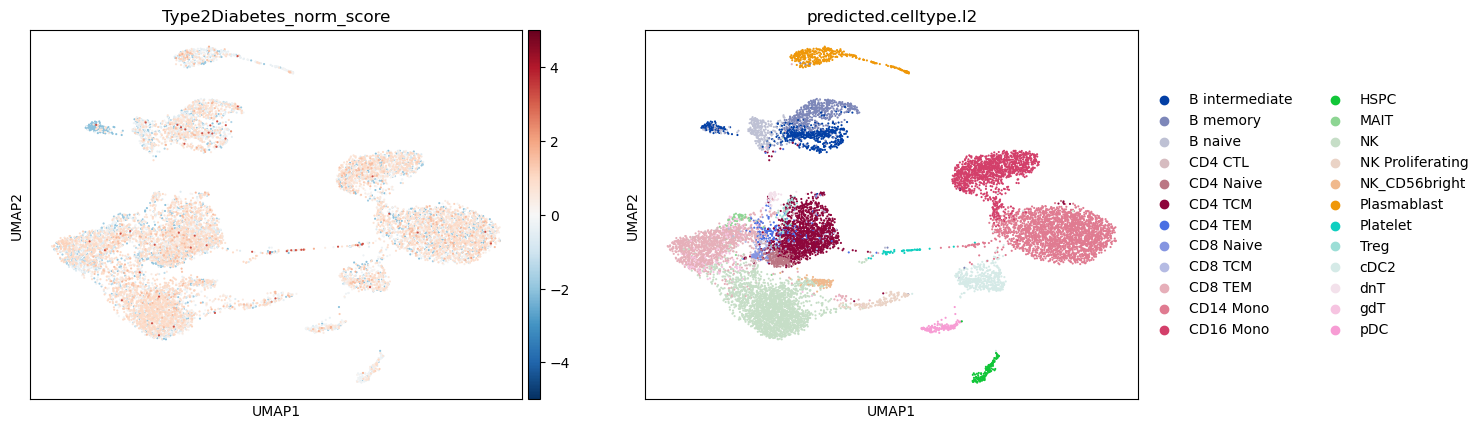

In [8]:
adata_scdrs = run_scdrs(
    dd.C,
    gene_sets=gene_sets,
    n_ctrl=1000,
    return_adata=True,
)

sc.pp.neighbors(adata_scdrs)
sc.tl.umap(adata_scdrs)

sc.pl.umap(
    adata_scdrs,
    color=["Type2Diabetes_norm_score", "predicted.celltype.l2"],
    cmap="RdBu_r",
    vmin=-5,
    vmax=5,
)

Found 67 significantly associated cells (p < 0.05)


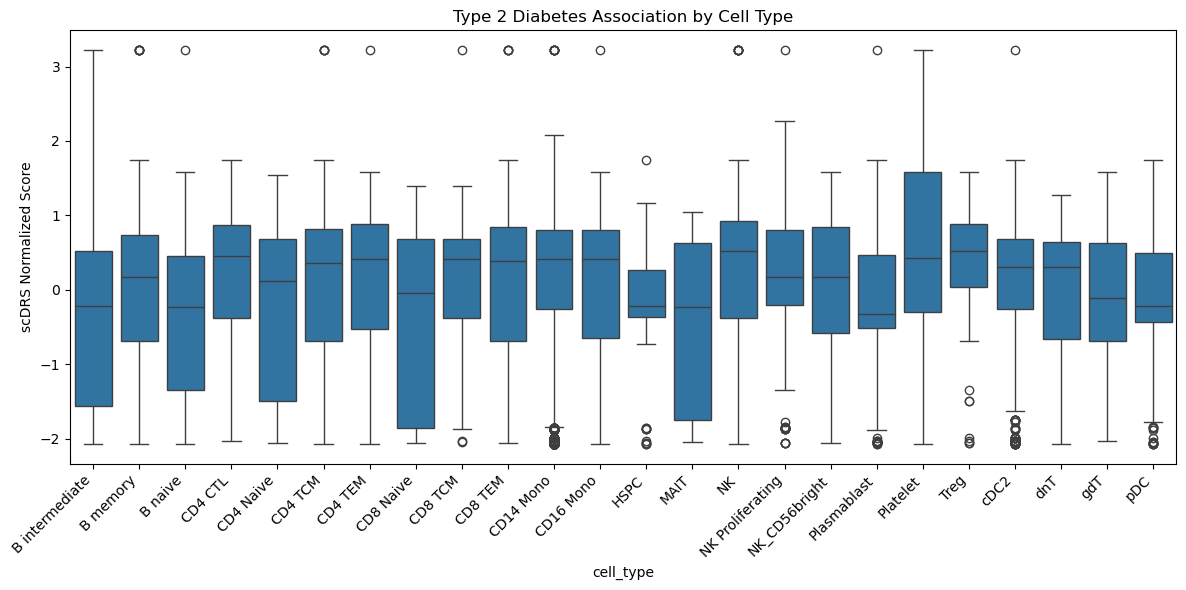

In [9]:
sig_cells = score_df[score_df["pval"] < 0.05]
print(f"Found {len(sig_cells)} significantly associated cells (p < 0.05)")

cell_type_scores = pd.DataFrame({
    "cell_type": adata_scdrs.obs["predicted.celltype.l2"],
    "disease_score": adata_scdrs.obs["Type2Diabetes_norm_score"]
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=cell_type_scores,
    x="cell_type",
    y="disease_score",
    ax=ax
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("scDRS Normalized Score")
plt.title("Type 2 Diabetes Association by Cell Type")
plt.tight_layout()
plt.savefig("scdrs_celltype_boxplot.png", dpi=300)

## Part 2: Seismic Analysis - Cell Type-Trait Associations
Seismic identifies which cell types are most relevant to a trait and finds the genes driving these associations.
### Running Seismic

In [10]:
associations = run_seismic(
    dd.C, 
    magma_file="trait.genes.out",  
    cell_type_col="predicted.celltype.l2",
    species="human",
    top_n_associations=20,
    prefix="t2d_seismic",
    plot_associations=True,
)

print("Top cell type-trait associations:")
print(associations.sort_values("pvalue").head(10)[
    ['cell_type', 'pvalue', 'FDR']
])

sig_celltypes = associations[associations['FDR'] < 0.05]
print(f"\nSignificant cell types (FDR < 0.05): {len(sig_celltypes)}")

[2026-01-07 22:45:47,020] INFO:cellink.tl.external._seismic: Preparing data for seismic analysis
[2026-01-07 22:45:47,021] INFO:cellink.tl.external._seismic: Filtering cells and genes
[2026-01-07 22:45:47,100] INFO:cellink.tl.external._seismic: Exporting data for R
[2026-01-07 22:46:11,105] INFO:cellink.tl.external._seismic: Saved expression matrix: t2d_seismic_expression.csv.gz
[2026-01-07 22:46:11,126] INFO:cellink.tl.external._seismic: Saved cell metadata: t2d_seismic_metadata.csv
[2026-01-07 22:46:11,134] INFO:cellink.tl.external._seismic: Created R script: t2d_seismic_seismic.R
[2026-01-07 22:46:11,134] INFO:cellink.tl.external._seismic: Running seismic analysis in R...
[2026-01-07 22:46:27,096] ERROR:cellink.tl.external._seismic: R script failed: Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys

RuntimeError: Seismic analysis failed: Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars

Lade nötiges Paket: GenomicRanges
Lade nötiges Paket: stats4
Lade nötiges Paket: BiocGenerics

Attache Paket: ‘BiocGenerics’

Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs

Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min

Lade nötiges Paket: S4Vectors

Attache Paket: ‘S4Vectors’

Das folgende Objekt ist maskiert ‘package:utils’:

    findMatches

Die folgenden Objekte sind maskiert von ‘package:base’:

    I, expand.grid, unname

Lade nötiges Paket: IRanges
Lade nötiges Paket: GenomeInfoDb
Lade nötiges Paket: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attache Paket: ‘Biobase’

Das folgende Objekt ist maskiert ‘package:MatrixGenerics’:

    rowMedians

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    anyMissing, rowMedians

Fehler in check_overlap(sscore, magma, magma_gene_col) : 
  Only 1 overlapping gene(s) between seismic specificity scores
         and the MAGMA input. This is below the minimum threshold needed to run.
         Please check the identifiers between
         these files or change the magma_gene_col and try again.
Ruft auf: get_ct_trait_associations -> check_overlap
Zusätzlich: Warnmeldung:
In check_overlap(sscore, magma, magma_gene_col) : Only 0% (0 genes)
          of genes map between seismic specificity scores and the MAGMA
          input. If this is unexpected, please check the identifiers between
          these files or change the magma_gene_col and try again.
Ausführung angehalten


## Part 3: Comparing Methods

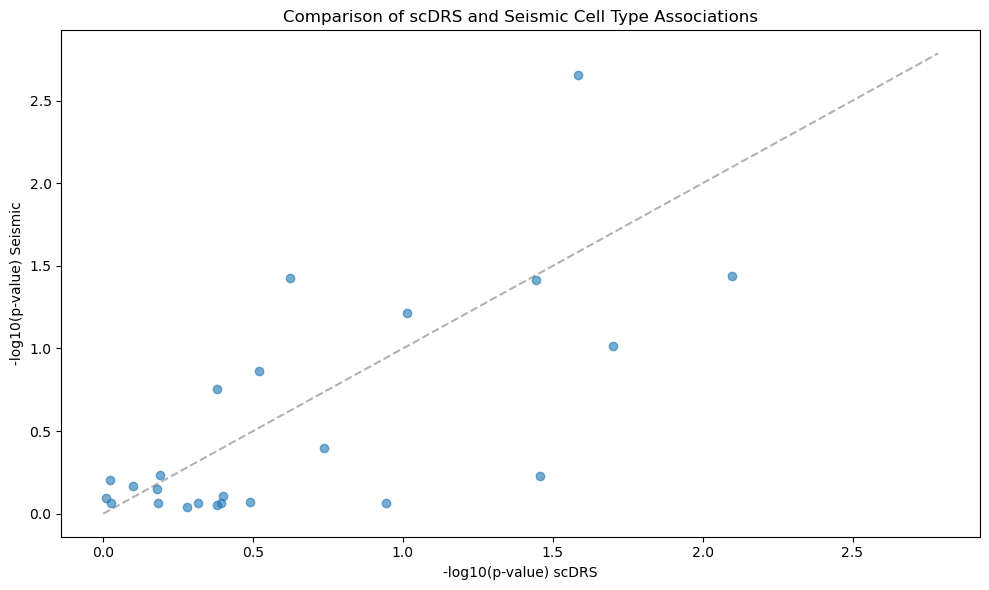

In [17]:
scdrs_ct = ct_results.copy()
scdrs_ct["method"] = "scDRS"
scdrs_ct["log_pval"] = -np.log10(scdrs_ct["assoc_mcp"])

seismic_ct = associations.copy()
seismic_ct["method"] = "Seismic"
seismic_ct["log_pval"] = -np.log10(seismic_ct["pvalue"])

fig, ax = plt.subplots(figsize=(10, 6))

comparison = pd.merge(
    scdrs_ct[["log_pval"]],
    seismic_ct[["cell_type", "log_pval"]],
    left_index=True,
    right_on="cell_type",
    suffixes=("_scDRS", "_Seismic")
)

ax.scatter(
    comparison["log_pval_scDRS"],
    comparison["log_pval_Seismic"],
    alpha=0.6
)
ax.set_xlabel("-log10(p-value) scDRS")
ax.set_ylabel("-log10(p-value) Seismic")
ax.set_title("Comparison of scDRS and Seismic Cell Type Associations")

lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

plt.tight_layout()
plt.savefig("scdrs_seismic_comparison.png", dpi=300)